# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 09 ноября 18:00 Сдача **очная** на онлайн занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0920, Задание 2] Фамилия Имя.



**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold

from tqdm.notebook import tqdm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [3]:
import warnings
warnings.filterwarnings('ignore')

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

$$ a_i = \langle X_i, w \rangle $$
$$ w = (w_0, w_1, w_2, .., w_D)$$
$$ \hat{w} = (w_1, w_2, .., w_D)$$
$$ \hat{w}_0 = (0, w_1, w_2, ..., w_D)$$
<br/>
$$ L(w) = \frac{1}{n}\left[\sum_{i} (y_i - \langle X_i, w \rangle)^{2}\right] + \frac{1}{C}\sum_{j = 1}^{D}w_{j}^{2} = $$
$$ = \frac{1}{n}\|{y - Xw}\|^{2} + \frac{1}{C}\|\hat{w}\|^{2} = $$
$$ = \frac{1}{n}(y - Xw)^{T}(y - Xw) + \frac{1}{C}\hat{w}^{T}\hat{w} = $$
$$ = \frac{1}{n}(y^{T}y - w^T X^T y - y^T Xw + w^{T}X^{T}Xw) + \frac{1}{C}\hat{w}^{T}\hat{w} $$
<br/>
$$ \nabla_{w}L(w) = \frac{1}{n}(-2X^{T}y + 2X^{T}Xw) + \frac{2}{C}\hat{w}_0 = $$
$$ = \frac{2}{n}(X^{T}Xw - X^{T}y) + \frac{2}{C}\hat{w}_0 = $$
$$ = \frac{2}{n}X^{T}(Xw - y) + \frac{2}{C}\hat{w}_0 $$

$$ w_{new} = w_{old} - 2\alpha\left[\frac{1}{n}X^{T}(Xw - y) + \frac{1}{C}\hat{w}_0\right] $$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$$ a_i = \sigma(\langle X_i, w \rangle) = \frac{1}{1 + e^{-\langle X_i, w \rangle}} $$
$$ w = (w_0, w_1, w_2, .., w_D)$$
$$ \hat{w} = (w_1, w_2, .., w_D)$$
$$ \hat{w}_0 = (0, w_1, w_2, ..., w_D)$$
<br/>
$$ L(w) = -\frac{1}{n}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] + \frac{1}{C}\sum_{j = 1}^{D}w_{j}^{2} = $$
$$ = -\frac{1}{n}\left[\sum_i y_i \log\left(\frac{1}{1 + e^{-\langle X_i, w \rangle}}\right) + ( 1 - y_i) \log\left(1 - \frac{1}{1 + e^{-\langle X_i, w \rangle}}\right) \right] + \frac{1}{C}\sum_{j = 1}^{D}w_{j}^{2} = $$
$$ = -\frac{1}{n}\left[\sum_i -y_i \log\left(\frac{1}{1 + e^{-\langle X_i, w \rangle}}\right) + ( 1 - y_i) \log\left(\frac{e^{-\langle X_i, w \rangle}}{1 + e^{-\langle X_i, w \rangle}}\right) \right] + \frac{1}{C}\sum_{j = 1}^{D}w_{j}^{2} = $$
$$ = -\frac{1}{n}\left[\sum_i -y_i \log(1 + e^{-\langle X_i, w \rangle}) + (1 - y_i)\left(-\langle X_i, w \rangle - \log(1 + e^{-\langle X_i, w \rangle})\right)\right] + \frac{1}{C}\sum_{j = 1}^{D}w_{j}^{2} = $$
$$ = -\frac{1}{n}\left[\sum_i -y_i \log(1 + e^{-\langle X_i, w \rangle}) - \langle X_i, w \rangle - \log(1 + e^{-\langle X_i, w \rangle}) + y_i \langle X_i, w \rangle + y_i \log(1 + e^{-\langle X_i, w \rangle})\right] + \frac{1}{C}\sum_{j = 1}^{D}w_{j}^{2} = $$
$$ = -\frac{1}{n}\left[\sum_i -\langle X_i, w \rangle - \log(1 + e^{-\langle X_i, w \rangle}) + y_i \langle X_i, w \rangle\right] + \frac{1}{C}\sum_{j = 1}^{D}w_{j}^{2} $$
<br/>
$$ \nabla_{w}L(w) = -\frac{1}{n}\left[\sum_i -X_i + \frac{e^{-\langle X_i, w \rangle}}{1 + e^{-\langle X_i, w \rangle}}X_i + y_i X_i \right] + \frac{2}{C}\hat{w}_0 = $$
$$ = -\frac{1}{n}\left[\sum_i \left(-1 + \frac{e^{-\langle X_i, w \rangle}}{1 + e^{-\langle X_i, w \rangle}} + y_i\right)X_i\right] + \frac{2}{C}\hat{w}_0 = $$
$$ = -\frac{1}{n}\left[\sum_i \left(y_i - \frac{1}{1 + e^{-\langle X_i, w \rangle}}\right)X_i\right] + \frac{2}{C}\hat{w}_0 = $$
$$ = -\frac{1}{n}\left[\sum_i \Big(y_i - \sigma(\langle X_i, w \rangle) \Big)X_i\right] + \frac{2}{C}\hat{w}_0 = $$
$$ = -\frac{1}{n} X^{T}\Big(y - \big(\sigma(Xw)\big) \Big) + \frac{2}{C}\hat{w}_0 = $$
$$ = \frac{1}{n} X^{T}\Big(\big(\sigma(Xw)\big) - y \Big) + \frac{2}{C}\hat{w}_0 = $$
<br/>
$$ w_{new} = w_{old} - \alpha\left[\frac{1}{n} X^{T}\Big(\big(\sigma(Xw)\big) - y \Big) + \frac{2}{C}\hat{w}_0\right]$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

(1)
<br/>
$$ Q(w) = \|Xw - y\|^2 = (Xw - y)^T(Xw - y) = $$
$$ = w^T X^T X w - w^T X^T y - y^T Xw + y^T y $$
<br/>
$$ H_w(Q(w)) = \nabla_w(\nabla_w(Q(w))) = \nabla_w(\nabla_w(w^T X^T X w - w^T X^T y - y^T Xw + y^T y)) = $$
$$ = \nabla_w(2X^TXw - 2X^Ty) = 2X^TX $$
<br/>
$$rank(X^TX) = rank(X) = D $$
<br/>
$X^TX$ - матрица Грамма, имеющая максимальный ранг $=>$ она положительно определена, а это является критерием минимума функции нескольких переменных в точке экстремума.

<br/>
(2) (применим $L2$-регуляризацию:)
<br/>
$$ Q(w) = \|Xw - y\|^2 + \frac{1}{C}\|\hat{w}\|^{2} = (Xw - y)^T(Xw - y) + \frac{1}{C}w^Tw $$
$$ = \frac{1}{n}(y - Xw)^{T}(y - Xw) + \frac{1}{C}w^{T}w = $$
$$ = \frac{1}{n}\big(y^{T}y - w^T X^T y - y^T Xw + w^{T}X^{T}Xw\big) + \frac{1}{C}w^{T}w $$
<br/>
$$ \nabla_w Q(w) = \nabla_w\Big(\big(y^{T}y - w^T X^T y - y^T Xw + w^{T}X^{T}Xw\big) + \frac{1}{C}w^{T}w\Big) = $$
$$ = 2X^{T}Xw - 2X^{T}y + \frac{2}{C}w $$
<br/>
$$ \nabla_w Q(w) = 0 <=> $$
$$ <=> 2X^{T}Xw - 2X^{T}y + \frac{2}{C}w = 0$$
$$ \big(2X^TX + \frac{2}{C}I\big)w = 2X^Ty $$
$$ w = \big(2X^TX + \frac{2}{C}I\big)^{-1}2X^Ty = \big(X^TX + \frac{1}{C}I\big)^{-1}X^Ty $$
<br/>
В случае, если матрица Х имеет линейно зависимые признаки, $L2$-регуляризация делает матрицу $\big(X^TX + \frac{1}{C}I\big)$ невырожденной $=>$ обратимой.

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

Обозначим:
$$ p_{1i} =  p(y_i = 1|x_i), p_{0i} = p(y_i = 0|x_i) = 1 - p_{1i}, a_i = a(x_i) $$
<br/>
$$ E(L|x_i) = -p_{1i} \log a_i  - p_{0i} \log( 1 - a_i) = $$
$$ = -p_{1i} \log a_i  - (1 - p_{1i}) \log( 1 - a_i) $$
<br/>
$$ E_{a_i}^{'}(L|x_i) = -\frac{p_{1i}}{a_i} + \frac{1 - p_{1i}}{1 - a_i} = \frac{a_i - p_{1i}}{a_i(1 - a_i)} $$
$$ E_{a_i}^{'}(L|x_i) = 0 <=> a_i = p_{1i} $$
<br/>
$$ E_{a_i a_i}^{''}(L|x_i) = \frac{1_i(1 - a_i) - (a_i - p_{1i})(1 - 2a_i)}{a_i^2 (1 - a_i)^2} = $$
$$ = \frac{a_i - a_i^2 - a_i + 2a_i^2 + p_{1i} - 2p_{1i}a_i}{a_i^2 (1 - a_i)^2} = $$
$$ = \frac{a_i^2 + p_{1i} - 2p_{1i}a_i}{a_i^2 (1 - a_i)^2} $$
<br/>
$$ E_{a_i a_i}^{''}(L|x_i) \bigg|_{a_i = p_{1i}} = \frac{p_{1i}^2 + p_{1i} - 2p_{1i}^2}{p_{1i}^2(1 - p_{1i})^2} = \frac{1}{p_{1i}(1 - p_{1i})} > 0 => $$
$=> a_i = p_{1i}$ является точкой экстремума функции матожидания $E_{a_i a_i}^{''}(L|x_i)$, и в этой точке достигается его минимум.

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Нет, $w_0$ не нужно использовать в регуляризации. Этот вес имеет смысл смещения, он сдвигает разделяющую поверхность относительно начала координат и никак не подгоняет модель под трейн.
<br/>
$w_0$ отвечает за "высоту" кривой предикта, а не за ее форму. Если использовать его в регуляризации, эта кривая только сместится ближе к началу координат.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [122]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [123]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [127]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [128]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [4]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """

    total_size = X.shape[0]
    indices = np.arange(total_size)

    if shuffle:
        np.random.shuffle(indices)

    for i in range(0, total_size, batch_size):
        batch_indices = indices[i:i + batch_size]
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [190]:
# %%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """

    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator=batch_generator,
                 C=1, alpha=0.01, max_epoch=10,
                 model_type='lin_reg', batch_size=1,
                 threshold=0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.batch_size = batch_size
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type
        self.threshold = threshold
        self.scaler = StandardScaler()

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        if self.model_type == 'lin_reg':
            a = X_batch @ self.weights
            loss = np.mean((a - y_batch) ** 2)
        elif self.model_type == 'log_reg':
            a = sigmoid(X_batch @ self.weights)
            loss = -np.mean((y_batch * np.log(a)) +
                            ((1 - y_batch) * np.log(1 - a)))

        loss += np.sum(self.weights[1:] ** 2) / self.C

        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу
        (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        if self.model_type == 'lin_reg':
            a = X_batch @ self.weights
            loss_grad = 2 * X_batch.T @ (a - y_batch)
        elif self.model_type == 'log_reg':
            a = sigmoid(X_batch @ self.weights)
            loss_grad = X_batch.T @ (a - y_batch)

        loss_grad /= y_batch.shape[0]
        loss_grad += 2 * np.r_[0, self.weights[1:]] / self.C

        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """

        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        # scaling
        X = self.scaler.fit_transform(X, y)
        # Добавим к X столбец фиктивных фичей-единиц
        X = np.c_[np.ones(shape=(X.shape[0])), X]

        # Нужно инициализровать случайно веса
        self.weights = -1 + 2 * np.random.rand(X.shape[1])

        for _ in range(self.max_epoch):
            new_epoch_generator = \
                self.batch_generator(X, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку
                # для отладки модели
                # До градиентного шага или после
                # - после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''

        # scaling
        X = self.scaler.transform(X)
        # Добавим к X столбец фиктивных фичей-единиц
        X = np.c_[np.ones(shape=(X.shape[0])), X]

        y_hat = X @ self.weights

        if self.model_type == 'log_reg':
            y_hat = sigmoid(y_hat)

        y_hat = (y_hat > self.threshold).astype(int)

        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [171]:
def plot_decision_boundary(clf, X):
    w_0, w_1, w_2 = clf.weights[:3]
    print(f'{clf.model_type}: {clf.weights}')

    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

    decision_bound = -(w_0 + w_1 * X[:, 0]) / w_2
    plt.plot(X[:, 0], decision_bound, label=clf.model_type)

lin_reg: [ 0.50999397  0.35379757 -0.15730142]
log_reg: [-0.24489695  2.06756686 -1.00251809]


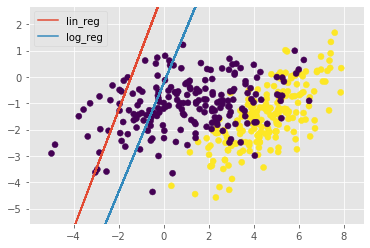

In [172]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf_lin_reg = MySGDClassifier(model_type='lin_reg', C=100)
clf_lin_reg.fit(X, y)
plot_decision_boundary(clf_lin_reg, X)

clf_log_reg = MySGDClassifier(model_type='log_reg', C=100)
clf_log_reg.fit(X, y)
plot_decision_boundary(clf_log_reg, X)

plt.legend()

plt.scatter(X[:, 0], X[:, 1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [173]:
from sklearn.datasets import make_classification

In [174]:
X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [175]:
N = 10
alpha_range = [0.001, 0.005, 0.008, 0.01, 0.05, 0.08]
batch_size = 100
max_epoch = 1

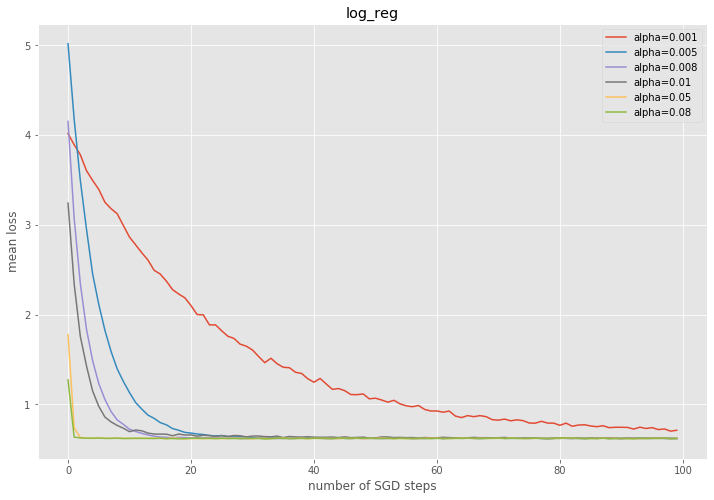

In [176]:
plt.figure(figsize=(12, 8))
plt.title('log_reg')
plt.xlabel('number of SGD steps')
plt.ylabel('mean loss')

for alpha in alpha_range:
    clf_log_reg = MySGDClassifier(alpha=alpha,
                                  batch_size=batch_size,
                                  max_epoch=max_epoch,
                                  model_type='log_reg')
    clf_log_reg.fit(X, y)

    log_reg_loss = np.asarray(clf_log_reg.errors_log['loss'])
    mean_log_reg_loss = np.asarray([
            np.mean(log_reg_loss[i:i + N])
            for i in range(0, log_reg_loss.shape[0], N)
    ])
    plt.plot(mean_log_reg_loss, label=f'alpha={alpha}')

plt.legend()

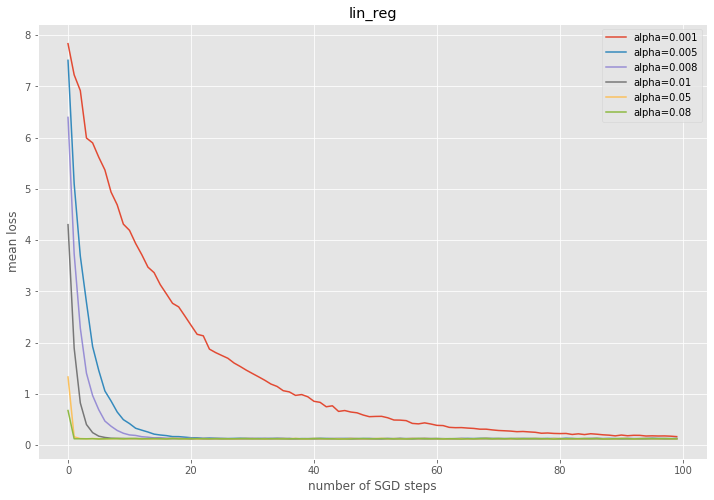

In [177]:
plt.figure(figsize=(12, 8))
plt.title('lin_reg')
plt.xlabel('number of SGD steps')
plt.ylabel('mean loss')

for alpha in alpha_range:
    clf_lin_reg = MySGDClassifier(alpha=alpha,
                                  batch_size=batch_size,
                                  max_epoch=max_epoch,
                                  model_type='lin_reg')
    clf_lin_reg.fit(X, y)

    lin_reg_loss = np.asarray(clf_lin_reg.errors_log['loss'])
    mean_lin_reg_loss = np.asarray([
            np.mean(lin_reg_loss[i:i + N])
            for i in range(0, lin_reg_loss.shape[0], N)
    ])
    plt.plot(mean_lin_reg_loss, label=f'alpha={alpha}')

plt.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

In [178]:
alpha_opt = 0.05
batch_size = 100
max_epoch = 10

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

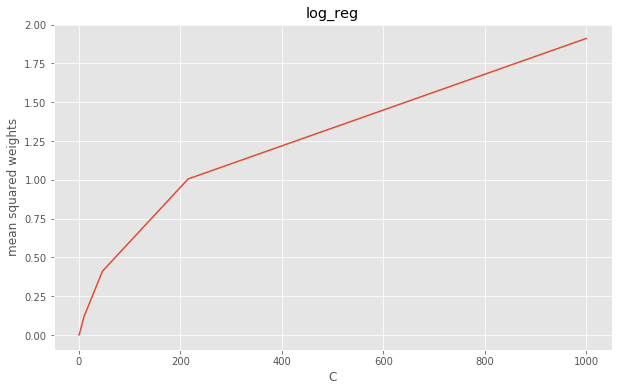

In [181]:
mean_sqrd_weights = []

for C in np.logspace(3, -3, 10):
    clf_log_reg = MySGDClassifier(alpha=alpha_opt,
                                  C=C,
                                  batch_size=batch_size,
                                  max_epoch=max_epoch,
                                  model_type='log_reg')
    clf_log_reg.fit(X, y)
    mean_sqrd_weights.append(np.mean(clf_log_reg.weights[1:] ** 2))

plt.figure(figsize=(10, 6))
plt.title('log_reg')
plt.xlabel('C')
plt.ylabel('mean squared weights')
plt.plot(np.logspace(3, -3, 10), mean_sqrd_weights)

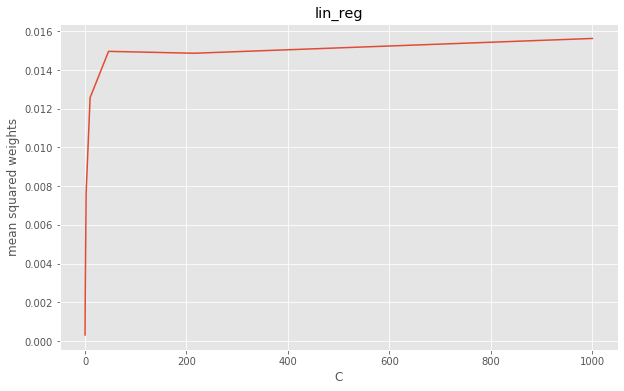

In [182]:
mean_sqrd_weights = []

for C in np.logspace(3, -3, 10):
    clf_lin_reg = MySGDClassifier(alpha=alpha_opt,
                                  C=C,
                                  batch_size=batch_size,
                                  max_epoch=max_epoch,
                                  model_type='lin_reg')
    clf_lin_reg.fit(X, y)
    mean_sqrd_weights.append(np.mean(clf_lin_reg.weights[1:] ** 2))

plt.figure(figsize=(10, 6))
plt.title('lin_reg')
plt.xlabel('C')
plt.ylabel('mean squared weights')
plt.plot(np.logspace(3, -3, 10), mean_sqrd_weights)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [203]:
doc_to_title = {}
with open('data/docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [204]:
train_data = pd.read_csv('data/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [205]:
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15])
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print(X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [122]:
my_clf = MySGDClassifier(model_type='log_reg', threshold=0.3)
clf = SGDClassifier()

In [123]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(f1_score(y_pred=clf.predict(X_train), y_true=y_train))
print(f1_score(y_pred=my_clf.predict(X_train), y_true=y_train))

0.5411678025419046
0.6130857391556651


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [213]:
def cross_val_score(n_splits=5, *args, **kwargs):
    my_clf = MySGDClassifier(*args, **kwargs)
    kf = KFold(n_splits=n_splits)

    scores = []

    for train_indices, test_indices in kf.split(X):
        X_train, X_test = X[train_indices, :], X[test_indices, :]
        y_train, y_test = y[train_indices], y[test_indices]
        my_clf.fit(X_train, y_train)
        scores.append(f1_score(y_pred=my_clf.predict(X_test),
                               y_true=y_test))
    scores = np.asarray(scores)

    return scores

In [214]:
opt_params = {}

In [215]:
def find_opt_param(param_name, param_range, known_params=opt_params):
    mean_scores = []

    for param in tqdm(param_range):
        kwargs = known_params
        kwargs.update({param_name: param})
        scores = cross_val_score(**kwargs)
        mean_scores.append(scores.mean())

    opt_param = param_range[np.argmax(mean_scores)]

    plt.figure(figsize=(10, 6))
    plt.xlabel(param_name)
    plt.ylabel('score')
    plt.title(f'Зависимость f1-score от параметра {param_name}, '
              'кросс-валидация.\n'
              f'Оптимальное значение параметра {param_name}: {opt_param}')
    plt.plot(param_range, mean_scores)

    return opt_param

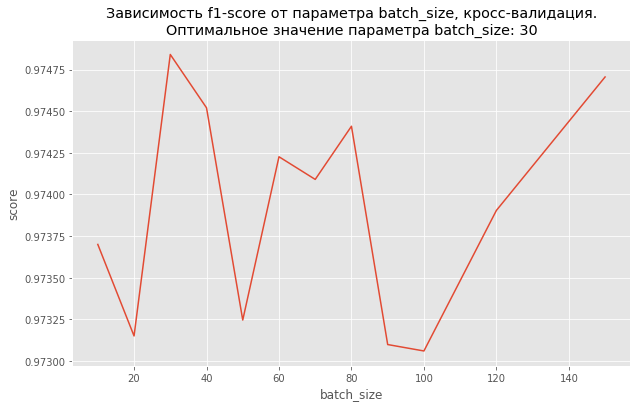

In [216]:
batch_size_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150]
opt_batch_size = find_opt_param('batch_size', batch_size_range)
opt_params.update({'batch_size': opt_batch_size})

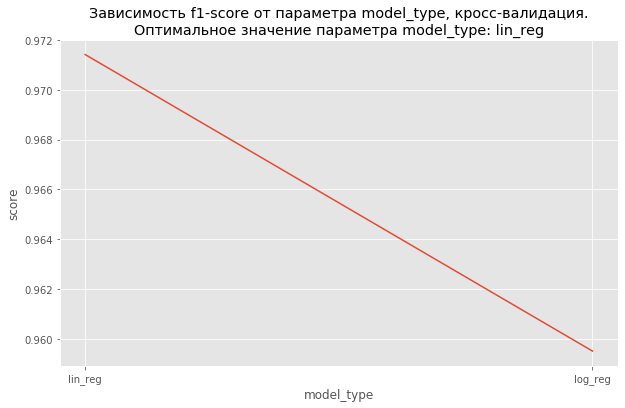

In [217]:
model_type_range = ['lin_reg', 'log_reg']
opt_model_type = find_opt_param('model_type', model_type_range)
opt_params.update({'model_type': opt_model_type})

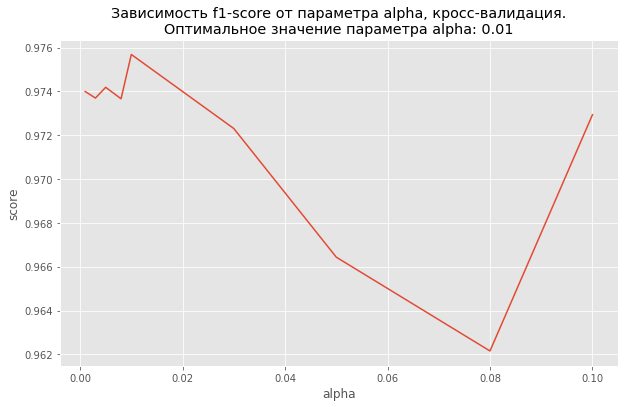

In [218]:
alpha_range = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1]
opt_alpha = find_opt_param('alpha', alpha_range)
opt_params.update({'alpha': opt_alpha})

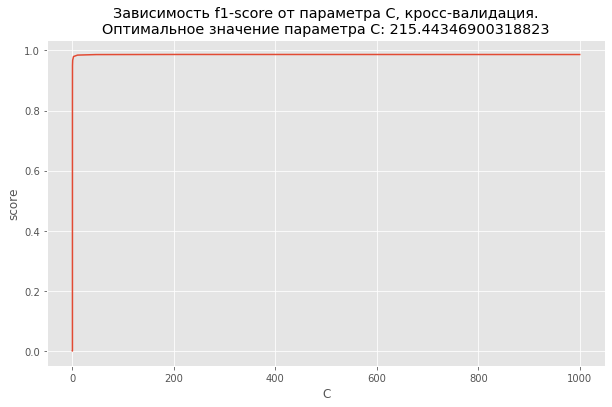

In [219]:
C_range = np.logspace(-3, 3, 10)
opt_C = find_opt_param('C', C_range)
opt_params.update({'C': opt_C})

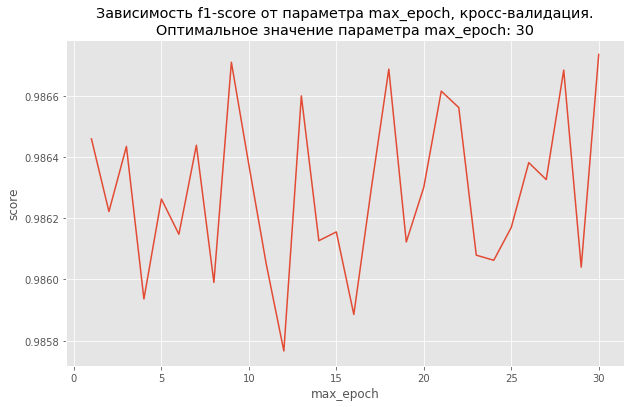

In [220]:
max_epoch_range = range(1, 31)
opt_max_epoch = find_opt_param('max_epoch', max_epoch_range)
opt_params.update({'max_epoch': opt_max_epoch})

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

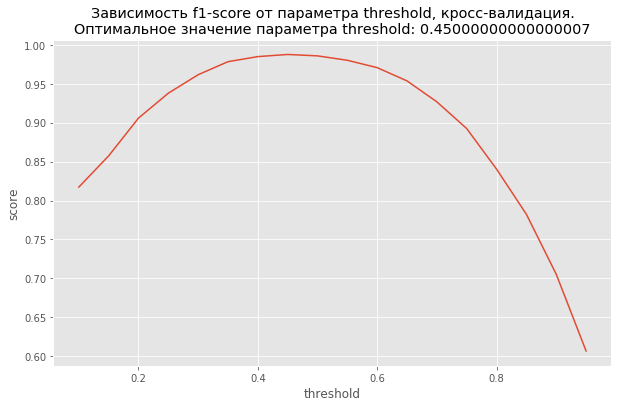

In [221]:
threshold_range = np.arange(0.1, 1, 0.05)
opt_threshold = find_opt_param('threshold', threshold_range)
opt_params.update({'threshold': opt_threshold})

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

In [222]:
test_data = pd.read_csv('data/test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    pair_id = new_doc['pair_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, pair_id, title))

X_test = []
pairs_id = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, pair_id, title) in enumerate(docs):
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            *_, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
        pairs_id.append(pair_id)
X_test = np.array(X_test)
print(X_test.shape)

(16627, 15)


In [230]:
%time

my_clf = MySGDClassifier(**opt_params)
my_clf.fit(X_train, y_train)

pred = my_clf.predict(X_test)

In [232]:
df = pd.DataFrame()
df['pair_id'] = pairs_id
df['target'] = pred

df.to_csv("data/sub.csv", header=True, index=False)

In [233]:
df

,pair_id,target
0,11691,0
1,11692,0
2,11693,1
3,11694,1
4,11695,0
...,...,...
16622,28313,0
16623,28314,0
16624,28315,0
16625,28316,0


** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***